In [1]:
'''
Video & Audio Confidence Classification Pipeline (modified version)
----------------------------------------------------------------

This script implements a complete pipeline for classifying interview videos
into three confidence classes (0, 1, 2) using two modalities:

* **Video** – frame‑level visual information processed by a pre‑trained
  VideoMAE model.  VideoMAE is a masked autoencoder trained on video data
  and can be used to extract meaningful visual representations for
  downstream tasks.
* **Audio** – speech information processed by a pre‑trained WavLM model.
  WavLM is a large‑scale self‑supervised speech model that operates on
  16 kHz audio and outputs latent speech representations suitable for
  tasks like classification or speaker identification.

This version modifies the original pipeline in four significant ways:

1. **Clip policy** – videos are split into 10‑second segments, but no
   synthetic segments or padding are created when fewer than five clips
   are available.  Segments shorter than five seconds are discarded.  If
   more than five valid clips exist, a subset of five is sampled evenly
   across the video; otherwise all available clips are used.  Augmentation
   is removed.
2. **Pooling strategy** – for each modality the per‑clip embeddings are
   aggregated by both mean and standard deviation.  These statistics are
   concatenated (mean∥std) for video and audio separately and then
   concatenated again (video_mean_std∥audio_mean_std) to form the final
   fused representation.  All intermediate statistics (mean, std,
   mean∥std) and the final fused vector are cached to disk.
3. **Early stopping** – the classifier training loop employs early
   stopping with a patience of three epochs based on the validation
   accuracy.  Training runs for at most 15 epochs but may terminate
   earlier if no improvement is seen.
4. **Expanded evaluation metrics** – balanced accuracy and macro F1 score
   are computed in addition to mean absolute error, quadratic weighted
   kappa, accuracy, Spearman’s ρ, and expected calibration error.  Both
   raw and normalized confusion matrices are displayed for each cross‑
   validation fold.

This script is designed for use in a Kaggle notebook.  To run it
successfully, copy its contents into a notebook cell and execute it.
It will install any missing dependencies, locate your dataset under
`/kaggle/input`, extract and cache features, perform five‑fold
cross‑validation with early stopping, and train a final MLP on all
available data.  The results and cached embeddings can be downloaded
from the `kaggle/working` directory.
'''

import os
import sys
import subprocess
import importlib
import warnings
import glob
import math
import random
from typing import List, Tuple

warnings.filterwarnings("ignore")

In [2]:
# -----------------------------------------------------------------------------
# 1) Environment setup
# -----------------------------------------------------------------------------

# Silence XDG/ALSA warnings that often appear when decoding audio in headless
# environments such as Kaggle.  This prevents clutter in the output.
os.environ.setdefault("XDG_RUNTIME_DIR", "/tmp/runtime-root")
os.makedirs(os.environ["XDG_RUNTIME_DIR"], exist_ok=True)
os.environ.setdefault("SDL_AUDIODRIVER", "dummy")


def ensure(pkg: str, import_name: str = None, min_version: str = None) -> None:
    '''Install a Python package if it is missing or older than `min_version`.'''
    name = import_name or pkg
    try:
        mod = importlib.import_module(name)
        if min_version:
            from importlib.metadata import version, PackageNotFoundError
            from packaging.version import Version
            try:
                ver = version(name)
                if Version(ver) < Version(min_version):
                    raise Exception(f"{name} < {min_version}")
            except PackageNotFoundError:
                raise
        return  # Already installed and up to date
    except Exception:
        spec = pkg if not min_version else f"{pkg}>={min_version}"
        print(f"[install] {spec}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", spec])


# Install essential dependencies.  We deliberately avoid pinning SciPy/Numpy
# versions to avoid conflicts with Kaggle’s environment.  SciPy will be
# patched after import if needed.
ensure("numpy")
ensure("pandas")
ensure("scikit-learn", "sklearn")
ensure("scipy")
ensure("seaborn")
ensure("matplotlib")
ensure("torch")
ensure("torchvision")
ensure("torchaudio")
ensure("transformers", min_version="4.31.0")
ensure("einops")
ensure("timm")
ensure("moviepy")
ensure("opencv-python-headless", "cv2")

In [4]:
# -----------------------------------------------------------------------------
# 2) Imports and SciPy patch
# -----------------------------------------------------------------------------

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    cohen_kappa_score,
    mean_absolute_error,
    balanced_accuracy_score,
    f1_score,
)
from scipy.stats import spearmanr

import scipy.integrate
# Patch SciPy ≥1.14 by aliasing simpson() to simps() if missing.  Some
# packages still expect `simps` to be present.
if not hasattr(scipy.integrate, "simps"):
    from scipy.integrate import simpson
    def _alias_simps(*args, **kwargs):
        return simpson(*args, **kwargs)
    scipy.integrate.simps = _alias_simps

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchaudio

from transformers import VideoMAEModel, WavLMModel
# Import VideoMAE feature extractor with fallback name
try:
    from transformers import VideoMAEImageProcessor as VideoMAEFeatureExtractor
except ImportError:
    from transformers import VideoMAEFeatureExtractor
# Use AutoFeatureExtractor for audio; returns a Wav2Vec2FeatureExtractor
from transformers import AutoFeatureExtractor

from moviepy.editor import VideoFileClip
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

print("[ok] Core imports loaded.")


[ok] Core imports loaded.


In [5]:
# -----------------------------------------------------------------------------
# 3) Reproducibility and constants
# -----------------------------------------------------------------------------

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Pre‑trained checkpoints for VideoMAE and WavLM
VIDEOMAE_CKPT = "MCG-NJU/videomae-base"
WAVLM_CKPT    = "microsoft/wavlm-base-plus"

# Video processing parameters
CLIP_SECONDS    = 10
FRAMES_PER_CLIP = 16
CLIPS_PER_VIDEO = 5
VIDEO_EXTS      = [".mp4", ".mov", ".mkv", ".avi", ".webm"]
CACHE_DIR       = "/kaggle/working/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# Training schedule
STAGE1_EPOCHS = 15
LR_STAGE1     = 1e-3
DROPOUT       = 0.3
WEIGHT_DECAY  = 1e-4
BATCH_SIZE    = 4

# Baseline comparison values (from the user’s reference metrics)
BASELINE = {"MAE": 1.000, "QWK": 0.000, "ACC": 0.167, "RHO": np.nan, "ECE": 0.317,
           "BAL": 0.167, "F1": 0.0}


In [6]:
# -----------------------------------------------------------------------------
# 4) Dataset discovery helpers
# -----------------------------------------------------------------------------

def find_dataset_root() -> Tuple[str, str, str]:
    '''Search under /kaggle/input for a dataset with a `videos/videos` folder and a CSV.'''
    candidates = glob.glob("/kaggle/input/*")
    for base in candidates:
        videos_dir = os.path.join(base, "videos", "videos")
        csvs = glob.glob(os.path.join(base, "*.csv"))
        if os.path.isdir(videos_dir) and csvs:
            return base, videos_dir, csvs[0]
    for base in candidates:
        for csv_path in glob.glob(os.path.join(base, "**", "*.csv"), recursive=True):
            parent = os.path.dirname(csv_path)
            vids = glob.glob(os.path.join(parent, "**", "videos"), recursive=True)
            for v in vids:
                vv = os.path.join(v, "videos")
                if os.path.isdir(vv):
                    return base, vv, csv_path
    raise FileNotFoundError("Dataset with videos/videos folder and a CSV not found.")


def read_labels(csv_path: str) -> pd.DataFrame:
    '''Read the CSV containing [video_filename, score] and ensure scores are ints.'''
    df = pd.read_csv(csv_path)
    df = df.rename(columns={df.columns[0]: "video_filename", df.columns[1]: "score"})
    df["score"] = df["score"].astype(int)
    return df


def resolve_video_path(videos_dir: str, filename: str) -> str:
    '''Resolve a video filename to an absolute path in `videos_dir`.
    Searches for the file with or without extension case‑insensitively.
    Returns None if not found.
    '''
    base = os.path.splitext(filename)[0]
    for ext in VIDEO_EXTS:
        candidate = os.path.join(videos_dir, base + ext)
        if os.path.isfile(candidate):
            return candidate
    cand = os.path.join(videos_dir, filename)
    if os.path.isfile(cand):
        return cand
    return None

In [12]:

# -----------------------------------------------------------------------------
# 5) Clip selection and augmentation (modified)
# -----------------------------------------------------------------------------

def split_into_segments(duration: float) -> List[Tuple[float, float]]:
    '''Split a video duration into 10‑second segments, with the last possibly shorter.'''
    n_full = int(duration // CLIP_SECONDS)
    starts = [i * CLIP_SECONDS for i in range(n_full)]
    rem = duration - n_full * CLIP_SECONDS
    segs = [(s, CLIP_SECONDS) for s in starts]
    if rem > 0:
        segs.append((n_full * CLIP_SECONDS, rem))
    return segs



def select_clips(video_path: str) -> List[dict]:
    """Return clip specs for a video under the new policy:
       - Split into 10 s segments; keep any remainder segment if it is >= 3 s.
       - If total segments >= CLIPS_PER_VIDEO:
           * Keep your original behavior: if there are > CLIPS_PER_VIDEO and a short tail,
             drop the tail (i.e., use only full 10 s segments), then sample exactly 5.
       - If total segments < CLIPS_PER_VIDEO: DO NOT augment or pad; just use what exists.
         (So a 4–5 s single-clip video is valid and will produce exactly one clip.)
    """
    with VideoFileClip(video_path) as v:
        dur = float(v.duration)

    # 10 s chunks + one remainder (could be < 10 s)
    segs_all = split_into_segments(dur)

    # keep full 10 s segments and any remainder >= 3 s
    segs_kept = [(s, d) for (s, d) in segs_all if d >= CLIP_SECONDS - 1e-3 or d >= 3.0]
    fulls     = [(s, d) for (s, d) in segs_kept if d >= CLIP_SECONDS - 1e-3]
    has_tail  = any(d < CLIP_SECONDS - 1e-3 for (_, d) in segs_kept)

    clips = []

    if len(segs_kept) >= CLIPS_PER_VIDEO:
        # Preserve your original >=5 behavior:
        # if there are more than needed and a short tail exists, drop the tail and use only fulls
        base = fulls if (len(segs_kept) > CLIPS_PER_VIDEO and has_tail) else segs_kept

        # sample exactly 5 evenly across 'base'
        idxs = np.round(np.linspace(0, len(base) - 1, CLIPS_PER_VIDEO)).astype(int).tolist()
        for i in idxs:
            s, d = base[i]
            # No extension; if this is a short (>=3s,<10s) segment that survived the branch above,
            # we still use its true duration without padding.
            clips.append({"start": s, "duration": min(d, CLIP_SECONDS), "extend": False, "aug": None})

    else:
        # Fewer than 5 segments: DO NOT augment or pad. Just keep what exists (>=3 s ones).
        # This allows single 4–5 s videos to pass with exactly one clip.
        for s, d in segs_kept:
            clips.append({"start": s, "duration": d, "extend": False, "aug": None})

        # If nothing remains (e.g., the whole video is < 3 s), raise a clear error
        # so the caller can decide to skip this item or clean the CSV.
        if not clips:
            raise ValueError(
                f"No usable segments (>=3 s) found in video '{os.path.basename(video_path)}' "
                f"(duration={dur:.2f}s). Consider removing it from labels."
            )

    return clips



def augment_frames(frames: List[np.ndarray], mode: str) -> List[np.ndarray]:
    '''Apply a simple augmentation to a list of RGB frames.

    Note: augmentations are retained for completeness but are no longer used in
    this modified pipeline.
    '''
    out = []
    for img in frames:
        if mode == "brightness":
            factor = np.clip(np.random.uniform(0.85, 1.15), 0.7, 1.3)
            aug = np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)
        elif mode == "contrast":
            alpha = np.clip(np.random.uniform(0.9, 1.1), 0.75, 1.25)
            aug = np.clip((img.astype(np.float32) - 127.5) * alpha + 127.5, 0, 255).astype(np.uint8)
        elif mode == "crop":
            h, w, _ = img.shape
            ch, cw = int(h * 0.9), int(w * 0.9)
            y0 = (h - ch) // 2
            x0 = (w - cw) // 2
            crop = img[y0:y0 + ch, x0:x0 + cw]
            aug = cv2.resize(crop, (w, h), interpolation=cv2.INTER_LINEAR)
        elif mode == "jitter":
            dx = np.random.randint(-2, 3)
            dy = np.random.randint(-2, 3)
            M = np.float32([[1, 0, dx], [0, 1, dy]])
            aug = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_REFLECT)
        else:
            aug = img
        out.append(aug)
    return out


def load_frames(video_path: str, start: float, duration: float, num_frames: int,
                extend: bool = False, augment: str = None) -> List[np.ndarray]:
    '''Load `num_frames` uniformly spaced frames from a video segment.'''
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_dur = total_frames / max(fps, 1e-6)
    target_dur = CLIP_SECONDS if extend else duration
    times = np.linspace(start, start + target_dur, num_frames, endpoint=False)
    frames = []
    for t in times:
        t_clamped = min(t, video_dur - 1e-3)
        frame_idx = int(round(t_clamped * fps))
        cap.set(cv2.CAP_PROP_POS_FRAMES, max(frame_idx, 0))
        ok, frame_bgr = cap.read()
        if not ok:
            if frames:
                frames.append(frames[-1])
            else:
                frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
            continue
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    if augment:
        frames = augment_frames(frames, augment)
    return frames


import subprocess as _sp
import tempfile
import wave
import contextlib


def extract_audio(video_path: str, start: float, duration: float, extend: bool = False,
                  target_sr: int = 16000) -> np.ndarray:
    '''Robust audio extractor that uses ffmpeg to extract mono audio.'''
    start = max(0.0, float(start))
    duration = max(0.0, float(duration))
    want_n = int(round(target_sr * duration))
    if want_n <= 0:
        return np.zeros(int(target_sr * duration), dtype=np.float32)
    tmpdir = tempfile.mkdtemp(prefix="aud_", dir="/kaggle/working")
    wav_path = os.path.join(tmpdir, "cut.wav")
    cmd = [
        "ffmpeg",
        "-hide_banner", "-loglevel", "error",
        "-ss", f"{start}",
        "-t", f"{duration}",
        "-i", video_path,
        "-vn",
        "-ac", "1",
        "-ar", str(target_sr),
        "-f", "wav",
        wav_path
    ]
    try:
        _sp.run(cmd, check=True)
        with contextlib.closing(wave.open(wav_path, "rb")) as wf:
            ch = wf.getnchannels()
            sr = wf.getframerate()
            nframes = wf.getnframes()
            raw = wf.readframes(nframes)
        audio = np.frombuffer(raw, dtype=np.int16).astype(np.float32) / 32768.0
        if len(audio) < want_n:
            audio = np.pad(audio, (0, want_n - len(audio)), mode="constant")
        elif len(audio) > want_n:
            audio = audio[:want_n]
        samples = audio
    except Exception:
        samples = np.zeros(want_n, dtype=np.float32)
    finally:
        try:
            if os.path.exists(wav_path):
                os.remove(wav_path)
            os.rmdir(tmpdir)
        except Exception:
            pass
    if extend:
        target_len = int(target_sr * CLIP_SECONDS)
        if len(samples) < target_len:
            if len(samples) == 0:
                samples = np.zeros(target_len, dtype=np.float32)
            else:
                reps = int(np.ceil(target_len / len(samples)))
                samples = np.tile(samples, reps)[:target_len]
    return samples

In [8]:

# -----------------------------------------------------------------------------
# 6) Model loading and embedding extraction (modified)
# -----------------------------------------------------------------------------

print("[load] Loading VideoMAE and WavLM models …")
videomae_processor = VideoMAEFeatureExtractor.from_pretrained(VIDEOMAE_CKPT)
wavlm_processor    = AutoFeatureExtractor.from_pretrained(WAVLM_CKPT)
videomae_model     = VideoMAEModel.from_pretrained(VIDEOMAE_CKPT).to(DEVICE).eval()
wavlm_model        = WavLMModel.from_pretrained(WAVLM_CKPT).to(DEVICE).eval()


def videomae_embedding(frames: List[np.ndarray]) -> torch.Tensor:
    '''Compute a VideoMAE embedding for a list of RGB frames.'''
    inputs = videomae_processor([frames], return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = videomae_model(**inputs)
        hidden = outputs.last_hidden_state.mean(dim=1)
    return hidden.squeeze(0).cpu()


def wavlm_embedding(audio_samples: np.ndarray, sr: int = 16000) -> torch.Tensor:
    '''Compute a WavLM embedding for a mono audio array.'''
    inputs = wavlm_processor(audio_samples, sampling_rate=sr, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = wavlm_model(**inputs)
        hidden = outputs.last_hidden_state.mean(dim=1)
    return hidden.squeeze(0).cpu()


def compute_video_embedding(video_path: str, cache_dir: str = CACHE_DIR):
    '''
    Compute and cache the fused embedding for a video.
    Extract per‑clip embeddings for both video and audio using VideoMAE and WavLM.
    Compute mean and standard deviation across clips for each modality, then
    concatenate these statistics to form the final fused vector.  Cache all
    intermediate vectors.
    Returns (fused, v_mean, a_mean, v_std, a_std, v_mean_std, a_mean_std) as
    torch.Tensors on CPU.
    '''
    base_name = os.path.splitext(os.path.basename(video_path))[0]
    cache_file = os.path.join(cache_dir, f"{base_name}.npz")
    specs = select_clips(video_path)
    video_embeds: List[torch.Tensor] = []
    audio_embeds: List[torch.Tensor] = []
    for spec in specs:
        start, dur, extend, aug = spec["start"], spec["duration"], spec["extend"], spec["aug"]
        frames = load_frames(video_path, start, dur, FRAMES_PER_CLIP, extend, aug)
        v_embed = videomae_embedding(frames)
        audio_samples = extract_audio(video_path, start, dur, extend)
        a_embed = wavlm_embedding(audio_samples)
        video_embeds.append(v_embed)
        audio_embeds.append(a_embed)
    if not video_embeds:
        raise RuntimeError(f"No valid clips extracted from {video_path}")
    v_tensor = torch.stack(video_embeds, dim=0)
    a_tensor = torch.stack(audio_embeds, dim=0)
    v_mean = v_tensor.mean(dim=0)
    a_mean = a_tensor.mean(dim=0)
    if v_tensor.shape[0] > 1:
        v_std = v_tensor.std(dim=0, unbiased=False)
    else:
        v_std = torch.zeros_like(v_mean)
    if a_tensor.shape[0] > 1:
        a_std = a_tensor.std(dim=0, unbiased=False)
    else:
        a_std = torch.zeros_like(a_mean)
    v_mean_std = torch.cat([v_mean, v_std], dim=0)
    a_mean_std = torch.cat([a_mean, a_std], dim=0)
    fused = torch.cat([v_mean_std, a_mean_std], dim=0)
    try:
        np.savez_compressed(
            cache_file,
            fused=fused.numpy(),
            vmae=v_mean.numpy(),
            vmae_std=v_std.numpy(),
            vmae_mean_std=v_mean_std.numpy(),
            wavl=a_mean.numpy(),
            wavl_std=a_std.numpy(),
            wavl_mean_std=a_mean_std.numpy(),
        )
    except Exception as e:
        print(f"[warn] Could not save cache for {video_path}: {e}")
    return fused, v_mean, a_mean, v_std, a_std, v_mean_std, a_mean_std


[load] Loading VideoMAE and WavLM models …


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [9]:
# -----------------------------------------------------------------------------
# 7) Classification and evaluation helpers (modified)
# -----------------------------------------------------------------------------

class MLP(nn.Module):
    '''Simple MLP classifier with one hidden layer and dropout.'''
    def __init__(self, in_dim: int, n_classes: int = 3, hidden: int = None, dropout: float = 0.3):
        super().__init__()
        h = hidden or max(128, in_dim // 2)
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h, n_classes),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def ece_score(probs: np.ndarray, labels: np.ndarray, bins: int = 15) -> float:
    '''Compute Expected Calibration Error (ECE) for multiclass predictions.'''
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    edges = np.linspace(0.0, 1.0, bins + 1)
    ece = 0.0
    for i in range(bins):
        lo, hi = edges[i], edges[i + 1]
        idx = (confidences > lo) & (confidences <= hi)
        if not np.any(idx):
            continue
        acc_bin = (predictions[idx] == labels[idx]).mean()
        conf_bin = confidences[idx].mean()
        ece += idx.mean() * abs(acc_bin - conf_bin)
    return float(ece)


def compute_metrics(logits: np.ndarray, y_true: np.ndarray):
    '''Compute evaluation metrics from logits.'''
    probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()
    y_pred = probs.argmax(axis=1)
    mae = mean_absolute_error(y_true, y_pred)
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    acc = accuracy_score(y_true, y_pred)
    rho, _ = spearmanr(y_true, y_pred)
    ece = ece_score(probs, y_true)
    bal = balanced_accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return {
        "MAE": mae,
        "QWK": float(qwk),
        "ACC": acc,
        "RHO": float(rho),
        "ECE": ece,
        "BAL": bal,
        "F1": f1,
    }, y_pred, probs


def plot_confusion(y_true: np.ndarray, y_pred: np.ndarray, title: str, normalize: bool = False) -> np.ndarray:
    '''Plot a confusion matrix and return the matrix.'''
    if normalize:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2], normalize="true")
        fmt = ".2f"
    else:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
        fmt = "d"
    df_cm = pd.DataFrame(cm, index=[0, 1, 2], columns=[0, 1, 2])
    plt.figure(figsize=(4.3, 3.6))
    sns.heatmap(df_cm, annot=True, fmt=fmt, cmap="Blues")
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()
    return cm


def train_classifier(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray) -> MLP:
    '''Train an MLP classifier on fused features with early stopping.'''
    in_dim = X_train.shape[1]
    model = MLP(in_dim, n_classes=3, hidden=min(512, max(128, in_dim // 2)), dropout=DROPOUT).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_STAGE1, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()
    train_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_ds   = torch.utils.data.TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    best_acc = -1.0
    best_state = None
    patience = 3
    epochs_since_improve = 0
    for epoch in range(1, STAGE1_EPOCHS + 1):
        model.train()
        loss_sum = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item() * len(xb)
        model.eval()
        with torch.no_grad():
            logits_all = []
            labels_all = []
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                logits_all.append(model(xb).cpu())
                labels_all.append(yb)
        logits_np = torch.cat(logits_all, dim=0).numpy()
        labels_np = torch.cat(labels_all, dim=0).numpy()
        val_acc = accuracy_score(labels_np, logits_np.argmax(axis=1))
        train_loss = loss_sum / len(train_ds) if len(train_ds) > 0 else 0.0
        print(f"      [epoch {epoch:02d}] train_loss={train_loss:.4f} val_acc={val_acc:.3f}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_since_improve = 0
        else:
            epochs_since_improve += 1
        if epochs_since_improve >= patience:
            print(f"      [early stopping] no improvement for {patience} epochs → stop training")
            break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model


In [10]:
# -----------------------------------------------------------------------------
# 8) Main pipeline
# -----------------------------------------------------------------------------

def main() -> None:
    print("[data] Locating dataset under /kaggle/input …")
    base, videos_dir, csv_path = find_dataset_root()
    print(f"    Video directory: {videos_dir}")
    print(f"    Labels CSV: {csv_path}")
    df = read_labels(csv_path)
    print(f"[data] Resolved {len(df)} videos with labels.")
    paths = []
    labels = []
    for _, row in df.iterrows():
        vp = resolve_video_path(videos_dir, str(row["video_filename"]))
        if vp is None:
            print(f"    [warn] Missing: {row['video_filename']} — skipping.")
            continue
        paths.append(vp)
        labels.append(int(row["score"]))
    df = pd.DataFrame({"path": paths, "label": labels})
    print(f"[data] {len(df)} existing videos will be processed.")
    X_list: List[np.ndarray] = []
    y_list: List[int] = []
    print("[feat] Extracting and caching fused features …")
    for i, row in df.iterrows():
        print(f"    [{i + 1}/{len(df)}] Processing {os.path.basename(row['path'])}")
        fused, v_mean, a_mean, v_std, a_std, v_mean_std, a_mean_std = compute_video_embedding(row["path"], CACHE_DIR)
        X_list.append(fused.numpy())
        y_list.append(row["label"])
    if not X_list:
        raise RuntimeError("No features were extracted. Check the dataset and cache directory.")
    X = np.stack(X_list, axis=0).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    print(f"[feat] Feature matrix shape: {X.shape}")
    print("[cv] Starting 5‑fold Stratified Cross‑Validation …")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    fold_results: List[dict] = []
    fold = 0
    for tr_idx, va_idx in skf.split(X, y):
        fold += 1
        print(f"\n[cv] Fold {fold}/5 — train={len(tr_idx)} val={len(va_idx)}")
        X_train, y_train = X[tr_idx], y[tr_idx]
        X_val, y_val   = X[va_idx], y[va_idx]
        model = train_classifier(X_train, y_train, X_val, y_val)
        with torch.no_grad():
            logits = model(torch.from_numpy(X_val).to(DEVICE)).cpu().numpy()
        metrics, y_pred, probs = compute_metrics(logits, y_val)
        print(f"[metrics][fold {fold}] "
              f"MAE={metrics['MAE']:.3f} QWK={metrics['QWK']:.3f} "
              f"ACC={metrics['ACC']:.3f} RHO={metrics['RHO']:.3f} "
              f"ECE={metrics['ECE']:.3f} BAL={metrics['BAL']:.3f} F1={metrics['F1']:.3f}")
        print(f"[compare][fold {fold}] vs baseline  "
              f"MAE={BASELINE['MAE']:.3f} QWK={BASELINE['QWK']:.3f} "
              f"ACC={BASELINE['ACC']:.3f} RHO={BASELINE['RHO']} "
              f"ECE={BASELINE['ECE']:.3f} BAL={BASELINE['BAL']:.3f} F1={BASELINE['F1']:.3f}")
        plot_confusion(y_val, y_pred, title=f"Confusion Matrix — Fold {fold}", normalize=False)
        plot_confusion(y_val, y_pred, title=f"Normalized Confusion Matrix — Fold {fold}", normalize=True)
        fold_results.append(metrics)
    df_res = pd.DataFrame(fold_results)
    print("\n[cv] Summary (mean ± std):")
    for key in ["MAE", "QWK", "ACC", "RHO", "ECE", "BAL", "F1"]:
        mean_val = df_res[key].mean()
        std_val  = df_res[key].std()
        print(f"    {key:>3}: {mean_val:.3f} ± {std_val:.3f}")
    print("\n[done] Pipeline execution complete.")


[data] Locating dataset under /kaggle/input …
    Video directory: /kaggle/input/interview-videos/videos/videos
    Labels CSV: /kaggle/input/interview-videos/labels_filenames_only.csv
[data] Resolved 79 videos with labels.
[data] 79 existing videos will be processed.
[feat] Extracting and caching fused features …
    [1/79] Processing anjaly_1.mp4
    [2/79] Processing anjaly_2.mp4
    [3/79] Processing anjaly_3.mp4
    [4/79] Processing anjaly_4.mp4
    [5/79] Processing anjaly_5.mp4
    [6/79] Processing anjaly_6.mp4
    [7/79] Processing blu1.mp4
    [8/79] Processing blu2.mp4
    [9/79] Processing blu3.mp4
    [10/79] Processing jani1.mp4
    [11/79] Processing jani2.mp4
    [12/79] Processing jani3.mp4
    [13/79] Processing jani4.mp4
    [14/79] Processing jani5.mp4
    [15/79] Processing jani6.mp4
    [16/79] Processing jani7.mp4
    [17/79] Processing jani8.mp4
    [18/79] Processing jani9.mp4
    [19/79] Processing jani10.mp4
    [20/79] Processing jani11.mp4
    [21/79] Proc

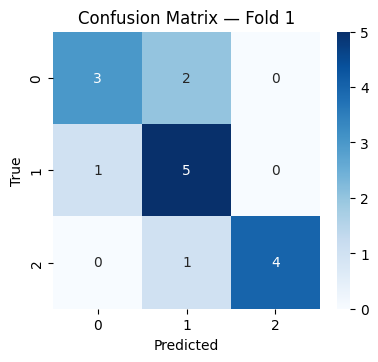

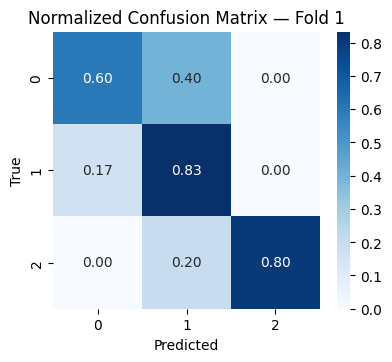


[cv] Fold 2/5 — train=63 val=16
      [epoch 01] train_loss=1.0187 val_acc=0.625
      [epoch 02] train_loss=0.7564 val_acc=0.750
      [epoch 03] train_loss=0.5976 val_acc=0.750
      [epoch 04] train_loss=0.6503 val_acc=0.875
      [epoch 05] train_loss=0.5501 val_acc=0.750
      [epoch 06] train_loss=0.5237 val_acc=0.750
      [epoch 07] train_loss=0.5109 val_acc=0.750
      [early stopping] no improvement for 3 epochs → stop training
[metrics][fold 2] MAE=0.125 QWK=0.889 ACC=0.875 RHO=0.916 ECE=0.181 BAL=0.867 F1=0.869
[compare][fold 2] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317 BAL=0.167 F1=0.000


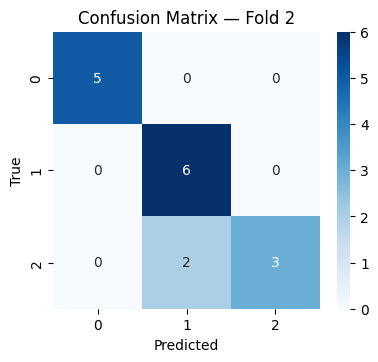

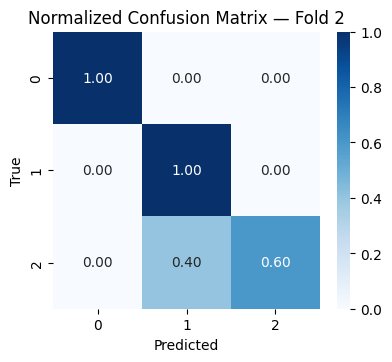


[cv] Fold 3/5 — train=63 val=16
      [epoch 01] train_loss=1.0216 val_acc=0.812
      [epoch 02] train_loss=0.7527 val_acc=0.812
      [epoch 03] train_loss=0.6391 val_acc=0.812
      [epoch 04] train_loss=0.5653 val_acc=0.812
      [early stopping] no improvement for 3 epochs → stop training
[metrics][fold 3] MAE=0.188 QWK=0.824 ACC=0.812 RHO=0.842 ECE=0.321 BAL=0.800 F1=0.813
[compare][fold 3] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317 BAL=0.167 F1=0.000


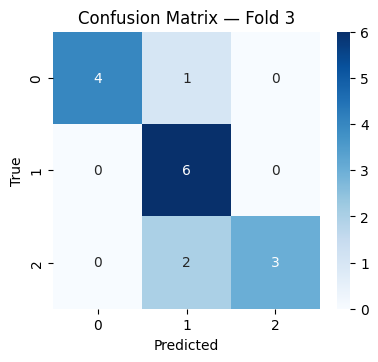

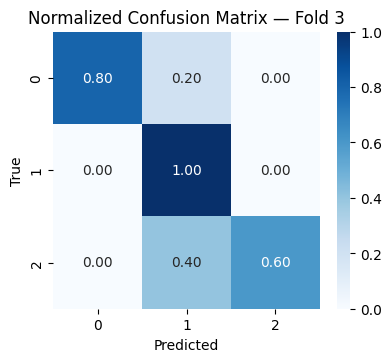


[cv] Fold 4/5 — train=63 val=16
      [epoch 01] train_loss=0.9901 val_acc=0.688
      [epoch 02] train_loss=0.6977 val_acc=0.625
      [epoch 03] train_loss=0.5603 val_acc=0.625
      [epoch 04] train_loss=0.4996 val_acc=0.688
      [early stopping] no improvement for 3 epochs → stop training
[metrics][fold 4] MAE=0.375 QWK=0.636 ACC=0.688 RHO=0.651 ECE=0.197 BAL=0.700 F1=0.678
[compare][fold 4] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317 BAL=0.167 F1=0.000


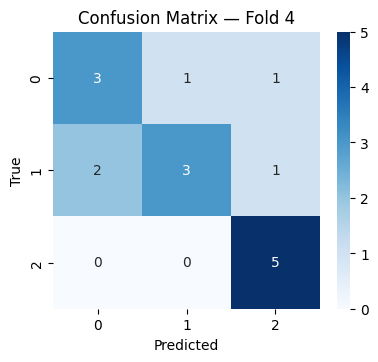

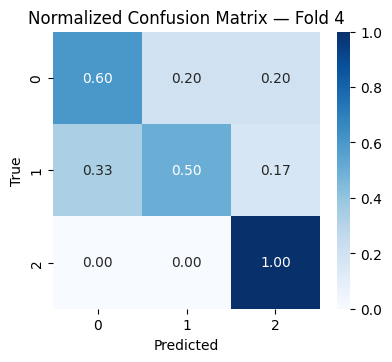


[cv] Fold 5/5 — train=64 val=15
      [epoch 01] train_loss=0.9810 val_acc=0.667
      [epoch 02] train_loss=0.7057 val_acc=0.600
      [epoch 03] train_loss=0.5536 val_acc=0.600
      [epoch 04] train_loss=0.4931 val_acc=0.600
      [early stopping] no improvement for 3 epochs → stop training
[metrics][fold 5] MAE=0.333 QWK=0.800 ACC=0.667 RHO=0.818 ECE=0.249 BAL=0.667 F1=0.534
[compare][fold 5] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317 BAL=0.167 F1=0.000


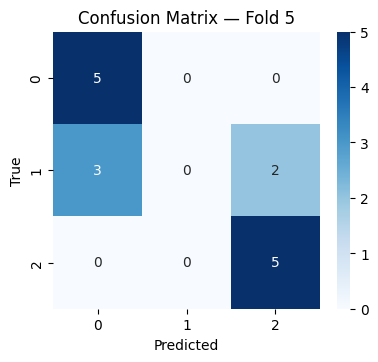

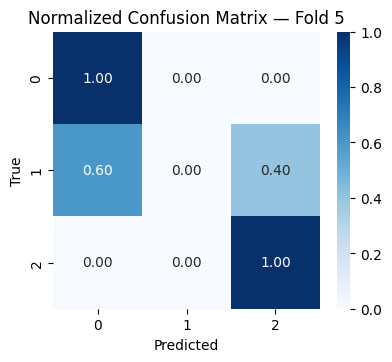


[cv] Summary (mean ± std):
    MAE: 0.254 ± 0.102
    QWK: 0.785 ± 0.093
    ACC: 0.758 ± 0.087
    RHO: 0.802 ± 0.097
    ECE: 0.239 ± 0.055
    BAL: 0.756 ± 0.080
     F1: 0.730 ± 0.130

[done] Pipeline execution complete.


In [13]:
# -----------------------------------------------------------------------------
# 9) Entry point
# -----------------------------------------------------------------------------

if __name__ == "__main__":
    main()


In [14]:
# === ZIP ALL CACHED .NPZ FILES ===
import os, glob, zipfile, datetime

# If you already have this defined earlier, reuse it:
CACHE_DIR = globals().get("CACHE_DIR", "/kaggle/working/cache_npz")  # <-- set to your cache folder
os.makedirs(CACHE_DIR, exist_ok=True)

# Name the zip with timestamp to avoid overwriting
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
ZIP_PATH = f"/kaggle/working/cached_features_{stamp}.zip"

npz_files = sorted(glob.glob(os.path.join(CACHE_DIR, "*.npz")))
if not npz_files:
    raise FileNotFoundError(f"No .npz found in {CACHE_DIR}. Did you run the feature-caching step?")

with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in npz_files:
        zf.write(p, arcname=os.path.basename(p))

print(f"[zip] Created: {ZIP_PATH}")
print("Download from the right-side 'Files' panel (kaggle/working).")


[zip] Created: /kaggle/working/cached_features_20251005-055043.zip
Download from the right-side 'Files' panel (kaggle/working).


In [15]:
# === FINAL MODEL ON ALL VIDEOS + ZIP BUNDLE ===
import os, glob, json, datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
import zipfile

# --------- Settings (reuse notebook globals when present) ----------
CACHE_DIR   = globals().get("CACHE_DIR", "/kaggle/working/cache")
LABELS_CSV  = globals().get("LABELS_CSV", None)
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE   = 16
EPOCHS       = 50            # upper bound; we’ll keep best-by-loss with early stopping
LR           = 1e-3
WEIGHT_DECAY = 1e-2
HIDDEN_DIM   = 512
DROPOUT      = 0.30
PATIENCE     = 3             # early stopping patience

SAVE_DIR       = "/kaggle/working"
FINAL_MODEL    = os.path.join(SAVE_DIR, "final_mlp.pt")
FINAL_CONFIG   = os.path.join(SAVE_DIR, "final_config.json")
FINAL_CLASSMAP = os.path.join(SAVE_DIR, "class_map.json")

os.makedirs(SAVE_DIR, exist_ok=True)

def _find_labels_csv():
    if LABELS_CSV and os.path.exists(LABELS_CSV):
        return LABELS_CSV
    # Try to discover the dataset CSV under /kaggle/input (same logic as earlier)
    for base in glob.glob("/kaggle/input/*"):
        csvs = glob.glob(os.path.join(base, "*.csv"))
        if csvs:
            return csvs[0]
    raise FileNotFoundError("Labels CSV not found. Please set LABELS_CSV or place CSV under /kaggle/input.")

def _stem(s):  # basename without extension, lowercased
    return os.path.splitext(os.path.basename(str(s)).lower().strip())[0]

def _load_all_fused_from_cache(cache_dir, labels_csv):
    # Read and normalize label file to (stem, label)
    df = pd.read_csv(labels_csv)
    df = df.rename(columns={df.columns[0]: "video_filename", df.columns[1]: "score"})
    y_raw = pd.to_numeric(df["score"], errors="coerce").astype(int)
    # map 1..3 -> 0..2 if needed
    if sorted(y_raw.unique().tolist()) == [1,2,3]:
        y_raw = y_raw - 1
    df = pd.DataFrame({
        "stem": df["video_filename"].apply(_stem),
        "y": y_raw
    })
    # Load .npz paths
    npz_paths = { _stem(p): p for p in glob.glob(os.path.join(cache_dir, "*.npz")) }
    if not npz_paths:
        raise FileNotFoundError(f"No .npz found in {cache_dir}. Build cache first.")
    X_list, y_list, miss = [], [], []
    for _, row in df.iterrows():
        s = row["stem"]
        p = npz_paths.get(s)
        if p is None:
            miss.append(s)
            continue
        data = np.load(p, allow_pickle=True)
        # Use the FINAL fused representation key (kept same name as pipeline)
        fused = data["fused"].astype("float32")
        X_list.append(fused)
        y_list.append(int(row["y"]))
    if miss:
        print(f"[warn] {len(miss)} label rows had no matching cache. Examples: {miss[:10]}")
    if not X_list:
        raise RuntimeError("No features matched labels. Check stems and cache dir.")
    X = np.vstack(X_list).astype("float32")
    y = np.array(y_list, dtype="int64")
    return X, y

class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden=HIDDEN_DIM, num_classes=3, p=DROPOUT):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x): return self.net(x)

def train_full_model(X, y):
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

    n_classes = len(sorted(set(y)))
    counts = np.bincount(y, minlength=n_classes)
    weights = counts.sum() / np.maximum(counts, 1)
    weights = weights / weights.mean()
    class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
    print(f"[train] class_weights={np.round(class_weights.cpu().numpy(),3).tolist()}")

    model = MLPHead(in_dim=X.shape[1], hidden=HIDDEN_DIM, num_classes=n_classes, p=DROPOUT).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit  = nn.CrossEntropyLoss(weight=class_weights)

    best_loss = float("inf")
    best_state = None
    bad_epochs = 0

    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss, total_correct, total_seen = 0.0, 0, 0
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()

            total_loss   += loss.item() * yb.size(0)
            total_correct += (logits.argmax(1) == yb).sum().item()
            total_seen   += yb.size(0)

        train_loss = total_loss / max(total_seen,1)
        train_acc  = total_correct / max(total_seen,1)
        print(f"[full-train] epoch {epoch:02d}/{EPOCHS} | loss={train_loss:.4f} acc={train_acc:.4f}")

        # Early stopping on train loss (since we’re training on ALL data)
        improved = train_loss < best_loss - 1e-6
        if improved:
            best_loss = train_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= PATIENCE:
                print(f"[early-stop] no improvement for {PATIENCE} epochs (best loss={best_loss:.4f}).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, n_classes

# ------------------ Build features & train ------------------
labels_csv = _find_labels_csv()
print(f"[load] LABELS_CSV: {labels_csv}")
print(f"[load] CACHE_DIR : {CACHE_DIR}")

X, y = _load_all_fused_from_cache(CACHE_DIR, labels_csv)
print(f"[data] X: {X.shape} | y: {y.shape} | classes: {sorted(set(y))} | counts: {Counter(y)}")

model, n_classes = train_full_model(X, y)

# ------------------ Save artifacts ------------------
save_obj = {
    "state_dict": model.state_dict(),
    "in_dim": int(X.shape[1]),
    "hidden_dim": int(HIDDEN_DIM),
    "num_classes": int(n_classes),
    "dropout": float(DROPOUT),
}
torch.save(save_obj, FINAL_MODEL)
print(f"[save] model -> {FINAL_MODEL}")

class_map = {int(i): f"class_{int(i)}" for i in sorted(set(y))}
with open(FINAL_CLASSMAP, "w") as f:
    json.dump(class_map, f, indent=2)
print(f"[save] class_map -> {FINAL_CLASSMAP}")

config = {
    "CACHE_DIR": CACHE_DIR,
    "LABELS_CSV": labels_csv,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "LR": LR,
    "WEIGHT_DECAY": WEIGHT_DECAY,
    "HIDDEN_DIM": HIDDEN_DIM,
    "DROPOUT": DROPOUT,
    "PATIENCE": PATIENCE,
    "SEED": 42,
    "DEVICE": DEVICE,
}
with open(FINAL_CONFIG, "w") as f:
    json.dump(config, f, indent=2)
print(f"[save] final_config -> {FINAL_CONFIG}")

# ------------------ Zip bundle for download ------------------
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
BUNDLE_ZIP = os.path.join(SAVE_DIR, f"final_model_bundle_{stamp}.zip")
with zipfile.ZipFile(BUNDLE_ZIP, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in [FINAL_MODEL, FINAL_CONFIG, FINAL_CLASSMAP]:
        if os.path.exists(p):
            zf.write(p, arcname=os.path.basename(p))
print(f"[zip] Created: {BUNDLE_ZIP}")
print("Download from the right-side 'Files' panel.")


[load] LABELS_CSV: /kaggle/input/interview-videos/labels_filenames_only.csv
[load] CACHE_DIR : /kaggle/working/cache
[data] X: (79, 3072) | y: (79,) | classes: [0, 1, 2] | counts: Counter({1: 29, 2: 25, 0: 25})
[train] class_weights=[1.0479999780654907, 0.9039999842643738, 1.0479999780654907]
[full-train] epoch 01/50 | loss=1.0640 acc=0.3797
[full-train] epoch 02/50 | loss=0.8002 acc=0.6835
[full-train] epoch 03/50 | loss=0.6672 acc=0.7215
[full-train] epoch 04/50 | loss=0.5812 acc=0.7595
[full-train] epoch 05/50 | loss=0.5098 acc=0.8101
[full-train] epoch 06/50 | loss=0.5337 acc=0.7722
[full-train] epoch 07/50 | loss=0.5195 acc=0.7595
[full-train] epoch 08/50 | loss=0.4800 acc=0.7722
[full-train] epoch 09/50 | loss=0.4556 acc=0.7848
[full-train] epoch 10/50 | loss=0.4322 acc=0.8101
[full-train] epoch 11/50 | loss=0.4162 acc=0.8228
[full-train] epoch 12/50 | loss=0.3965 acc=0.8101
[full-train] epoch 13/50 | loss=0.3928 acc=0.8101
[full-train] epoch 14/50 | loss=0.3996 acc=0.8228
[full-

In [16]:
# === ROBUST INFERENCE SMOKE TEST ===
import os, glob, json, torch, numpy as np
import torch.nn as nn

def find_model_path():
    pref = "/kaggle/working/final_mlp.pt"
    if os.path.exists(pref): return pref
    candidates = sorted(glob.glob("/kaggle/working/*.pt") + glob.glob("/kaggle/working/*.pth"),
                        key=os.path.getmtime, reverse=True)
    if not candidates:
        raise FileNotFoundError("No model file found in /kaggle/working. Run the training cell first.")
    return candidates[0]

def find_one_npz():
    # prefer the chosen CACHE_DIR
    if os.path.isdir(CACHE_DIR):
        picks = glob.glob(os.path.join(CACHE_DIR, "*.npz"))
        if picks: return sorted(picks)[0]
    # fallback search
    picks = sorted(glob.glob("/kaggle/working/**/*.npz", recursive=True))
    if not picks:
        raise FileNotFoundError("No .npz found under /kaggle/working. Build cache first.")
    return picks[0]

MODEL_PATH = find_model_path()
ckpt = torch.load(MODEL_PATH, map_location="cpu")
in_dim      = int(ckpt["in_dim"])
hidden_dim  = int(ckpt["hidden_dim"])
num_classes = int(ckpt["num_classes"])
dropout     = float(ckpt.get("dropout", 0.3))

class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden, num_classes, p=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x): return self.net(x)

model = MLPHead(in_dim, hidden_dim, num_classes, p=dropout)
model.load_state_dict(ckpt["state_dict"], strict=True)
model.eval()

# optional class map
CLASSMAP_JS = "/kaggle/working/class_map.json"
if os.path.exists(CLASSMAP_JS):
    try:
        with open(CLASSMAP_JS, "r") as f:
            tmp = json.load(f)
        class_map = {int(k): v for k, v in tmp.items()}
    except Exception:
        class_map = {i: f"class_{i}" for i in range(num_classes)}
else:
    class_map = {i: f"class_{i}" for i in range(num_classes)}

sample_npz = find_one_npz()
vec = np.load(sample_npz, allow_pickle=True)["fused"].astype("float32")
x = torch.from_numpy(vec).unsqueeze(0)

with torch.no_grad():
    logits = model(x)
    prob = torch.softmax(logits, dim=1).squeeze(0).numpy()
    pred = int(prob.argmax())

print(f"[inference] model={os.path.basename(MODEL_PATH)} | sample={os.path.basename(sample_npz)}")
print(f"           pred={pred} ({class_map.get(pred, pred)}) | probs={np.round(prob,3)}")


[inference] model=final_mlp.pt | sample=anjaly_1.npz
           pred=1 (class_1) | probs=[0.008 0.566 0.426]
